# Chest X-Ray Medical Diagnosis with Deep Learning

# Model Interpretation Methods

<img src="xray-header-image.png" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

In [1]:
!pip install opendatasets

# ❗❗❗❗

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/nih-chest-xrays/sample/data')
#username ve key kısmına aşağıdakileri yapıştırın
#username: iremdeniz
#key: 088768a47e5047187387b5fa9a05c53b

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iremdeniz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample


In [3]:
# Import necessary packages
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle

sns.set()

# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]

# ❗❗❗❗
test,val,train'i nereye eklediyseniz o yol ile güncelleyinn


In [4]:
# Read csv file containing training datadata
train_df = pd.read_csv("/content/train_final.csv")
valid_df = pd.read_csv("/content/val_final.csv")
test_df = pd.read_csv("/content/test_final.csv")
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in the train data frame')
train_df.head()

There are 3924 rows and 15 columns in the train data frame


,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,00006593_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00026132_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00002735_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00018472_005.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00018025_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
!pip install -U imbalanced-learn

In [6]:
!pip install scikit-multilearn imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.3 MB/s eta 0:00:00


In [7]:
!pip install scikit-multilearn

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator

def augment_and_save(original_image_path, save_path):
    img = load_img(original_image_path, target_size=(320, 320))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 0)
    datagen = ImageDataGenerator(
        rotation_range=25,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest')
    aug_iter = datagen.flow(img_array, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.uint8)
    array_to_img(aug_image).save(save_path)

def MLSMOTE(X, class_idx, n_samples, n_labels, k_neighbors=5):
    neighbors = NearestNeighbors(n_neighbors=k_neighbors+1).fit(X)
    indices = neighbors.kneighbors(X, return_distance=False)[:, 1:]
    synthetic_X = []
    synthetic_y = []
    for _ in range(n_samples):
        idx = np.random.randint(0, len(X))
        neighbor_idx = np.random.choice(indices[idx])
        diff = X[neighbor_idx] - X[idx]
        gap = np.random.rand()
        synthetic_sample = X[idx] + gap * diff
        synthetic_X.append(synthetic_sample)
        label = np.zeros(n_labels)
        label[class_idx] = 1
        synthetic_y.append(label)
    return np.array(synthetic_X), np.array(synthetic_y)

# Veriyi oku
df = pd.read_csv('/content/train_final.csv')
columns = df.columns[1:]  # Hastalık isimleri
n_labels = len(columns)
TARGET_COUNT = 400
image_dir = "/content/sample/sample/sample/images/"
os.makedirs(image_dir, exist_ok=True)

df_syn_total = []
df_final_total = []

# Her sınıf için tek tek çalış
for class_idx, col in enumerate(columns):
    df_class = df[df[col] == 1]
    current_count = len(df_class)
    print(f"{col} → {current_count} örnek")

    if current_count < 2:
        print(f"Yetersiz veri: {col}, atlanıyor...")
        continue

    if current_count < TARGET_COUNT:
        needed = TARGET_COUNT - current_count
        X_class = np.arange(current_count).reshape(-1, 1)
        file_names = df_class['Image Index'].values
        X_syn, y_syn = MLSMOTE(X_class, class_idx, needed, n_labels)
        df_syn = pd.DataFrame(y_syn, columns=columns)
        synthetic_image_names = []

        for i in range(len(df_syn)):
            base_img = np.random.choice(file_names)
            base_img_path = os.path.join(image_dir, base_img)
            synthetic_name = f'synthetic_{col}_{i}.png'
            synthetic_path = os.path.join(image_dir, synthetic_name)
            augment_and_save(base_img_path, synthetic_path)
            synthetic_image_names.append(synthetic_name)

        df_syn.insert(0, 'Image Index', synthetic_image_names)
        df_syn_total.append(df_syn)
        df_final_total.append(df_class)

    elif current_count > TARGET_COUNT:
        df_under = df_class.sample(n=TARGET_COUNT, random_state=42)
        df_final_total.append(df_under)

    else:
        df_final_total.append(df_class)

# Sonuçları birleştir
df_all = pd.concat(df_final_total + df_syn_total, ignore_index=True)
df_all = shuffle(df_all).reset_index(drop=True)
df_all.to_csv("/content/train_balanced.csv", index=False)

# Sonuçları yaz
print("\n✅ Tamamlandı.")
print("Yeni veri şekli:", df_all.shape)
print("Etiket dağılımı (sonra):")
print(df_all[columns].sum())


Cardiomegaly → 94 örnek
Emphysema → 90 örnek
Effusion → 455 örnek
Hernia → 10 örnek
Nodule → 212 örnek
Pneumothorax → 174 örnek
Atelectasis → 361 örnek
Pleural_Thickening → 113 örnek
Mass → 210 örnek
Edema → 79 örnek
Consolidation → 163 örnek
Infiltration → 713 örnek
Fibrosis → 57 örnek
Pneumonia → 46 örnek

✅ Tamamlandı.
Yeni veri şekli: (5600, 15)
Etiket dağılımı (sonra):
Cardiomegaly          490.0
Emphysema             492.0
Effusion              827.0
Hernia                410.0
Nodule                550.0
Pneumothorax          542.0
Atelectasis           711.0
Pleural_Thickening    513.0
Mass                  594.0
Edema                 468.0
Consolidation         581.0
Infiltration          905.0
Fibrosis              440.0
Pneumonia             465.0
dtype: float64


In [9]:
def check_for_leakage(df1, df2, patient_col):

    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])

    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) > 0


    return leakage

### Explore data labels
Create a list of the names of each patient condition or disease.

In [10]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Image Index', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']


In [11]:
# SMOTE uygulanmış yeni veri çerçevesi: augmented_df

# Etiket kolonlarını al (Image Index hariç)
# df_syn_total'ın tüm elemanlarını bir DataFrame'de birleştir
# df_all zaten bir DataFrame, concat için iterable bir nesneye ihtiyacımız var
# Örneğin, df_all'ı bir liste içine alabilirsiniz:
df_syn_total = pd.concat([df_all], ignore_index=True)
columns = df_all.columns[1:]

# Toplam sınıf sayısı
print(f"There are {len(columns)} columns of labels for these conditions: {list(columns)}")

# Her sınıf için pozitif örnek sayısını yazdır
for column in columns:
    print(f"The class '{column}' has {df_all[column].sum()} samples")

There are 14 columns of labels for these conditions: ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass', 'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']
The class 'Cardiomegaly' has 490.0 samples
The class 'Emphysema' has 492.0 samples
The class 'Effusion' has 827.0 samples
The class 'Hernia' has 410.0 samples
The class 'Nodule' has 550.0 samples
The class 'Pneumothorax' has 542.0 samples
The class 'Atelectasis' has 711.0 samples
The class 'Pleural_Thickening' has 513.0 samples
The class 'Mass' has 594.0 samples
The class 'Edema' has 468.0 samples
The class 'Consolidation' has 581.0 samples
The class 'Infiltration' has 905.0 samples
The class 'Fibrosis' has 440.0 samples
The class 'Pneumonia' has 465.0 samples


# ❗❗❗❗
img_dir yolunu kontrol edin

Display Random Images


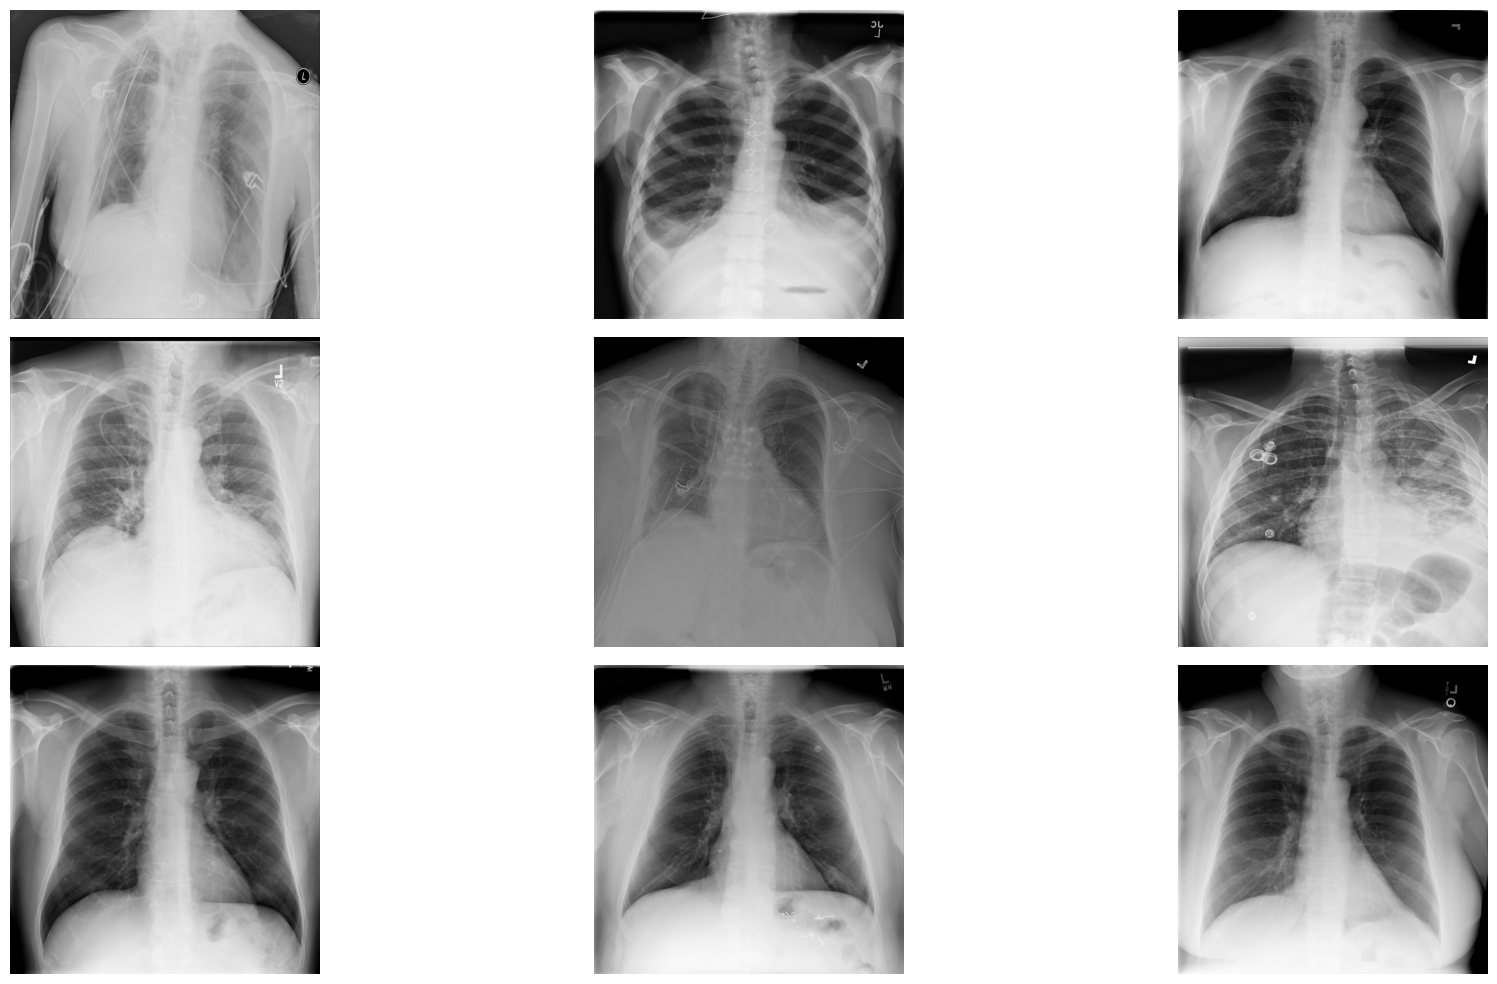

In [12]:

images = train_df['Image Index'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = '/content/sample/sample/sample/images/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# Adjust subplot parameters to give specified padding
plt.tight_layout()

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 0.9333 and the minimum is 0.0000
The mean value of the pixels is 0.6367 and the standard deviation is 0.1615


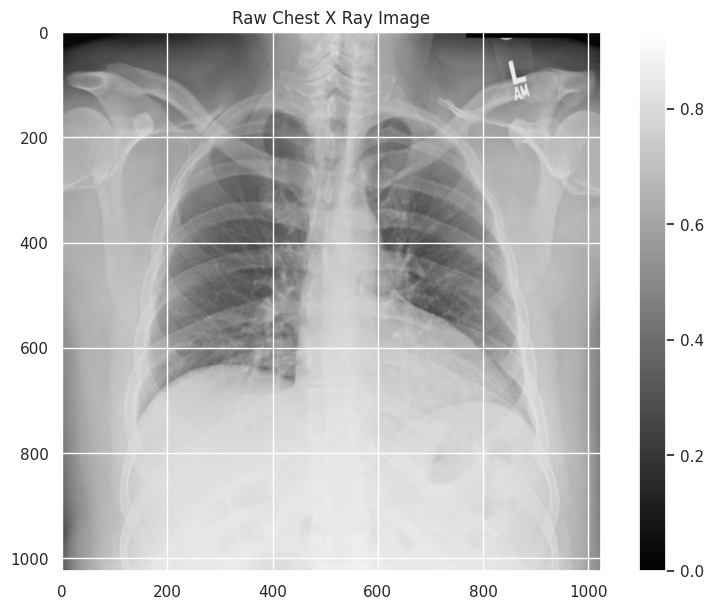

In [13]:
# İlk görüntünün dosya adını alırken 'Image Index' sütununu kullan
sample_img = train_df["Image Index"].iloc[0]

# Görüntüyü yükle ve görselleştir
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.grid(color='w', linestyle='-', linewidth=1)
plt.colorbar()
plt.title('Raw Chest X Ray Image')

# Görüntü bilgilerini ekrana yazdır
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")


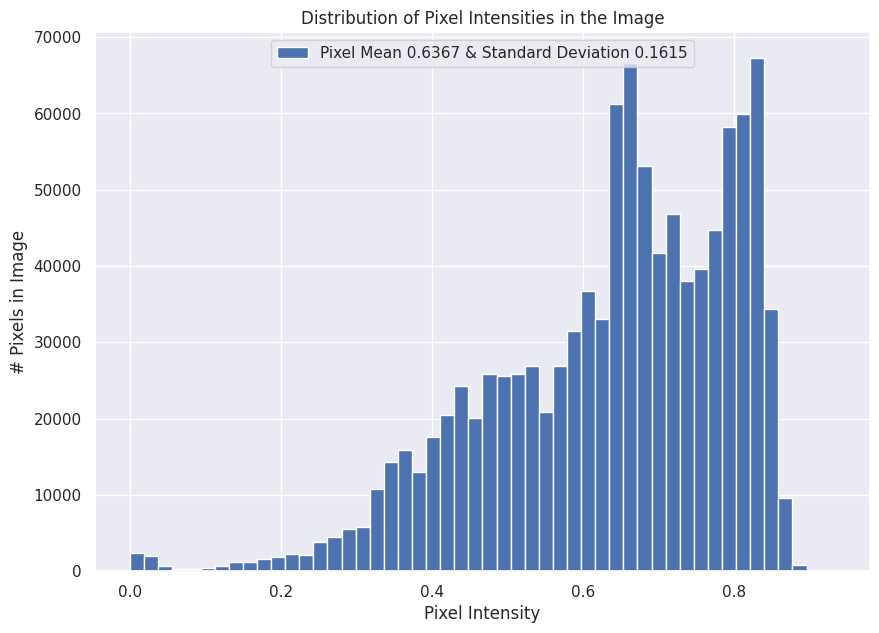

In [14]:
pixels = np.reshape(raw_image,raw_image.shape[0]*raw_image.shape[1])
plt.hist(pixels, bins=50, label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}')
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')
plt.show()

In [15]:
# Import data generator from keras https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_train_generator(df_all, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    print("getting train generator...")

    # Veri artırma + normalizasyon
    image_generator = ImageDataGenerator(
        rotation_range=25,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest',
        samplewise_center=True,                # Her görüntüyü ortalaması 0 olacak şekilde ayarla
        samplewise_std_normalization=True     # Her görüntüyü kendi std’si ile normalize et
    )

    generator = image_generator.flow_from_dataframe(
        dataframe=df_all,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",  # Çoklu etiket (multi-label) için raw
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h)
    )

    return generator


In [17]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8,
                                 seed=1, target_w=320, target_h=320):

    print(f"\nextracting {sample_size} train images to normalize validation and test datasets...")

    # Eğitim verisinden küçük bir örnek al (sadece orijinal train_df kullanılır)
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h)
    )

    batch = raw_train_generator.__next__()
    data_sample = batch[0]  # Sadece görüntüler alınır (etiket değil)

    # Validasyon ve test için normalization ayarı
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True
    )

    # Normalizasyon değerlerini eğitim örneklerinden öğren
    image_generator.fit(data_sample)

    print("\ngetting valid generator...")
    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )

    print("\ngetting test generator...")
    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h)
    )

    return valid_generator, test_generator


In [18]:
print(df_all.columns)


Index(['Image Index', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
       'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass',
       'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia'],
      dtype='object')


# ❗❗❗❗
IMAGE_DIR yolunu kontrol edin

In [19]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
          'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass',
           'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']

IMAGE_DIR = "/content/sample/sample/sample/images/"

# Eğitim verisi: SMOTE + undersample uygulanmış, dengeli veri çerçevesi
train_generator = get_train_generator(df_all, IMAGE_DIR, "Image Index", labels)

# Validasyon ve test setleri: orijinal veriler
valid_generator, test_generator = get_test_and_valid_generator(
    valid_df, test_df, train_df, IMAGE_DIR, "Image Index", labels
)


getting train generator...
Found 5600 validated image filenames.

extracting 100 train images to normalize validation and test datasets...
Found 3924 validated image filenames.

getting valid generator...
Found 841 validated image filenames.

getting test generator...
Found 841 validated image filenames.


The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.1132 and the minimum is -3.2360
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


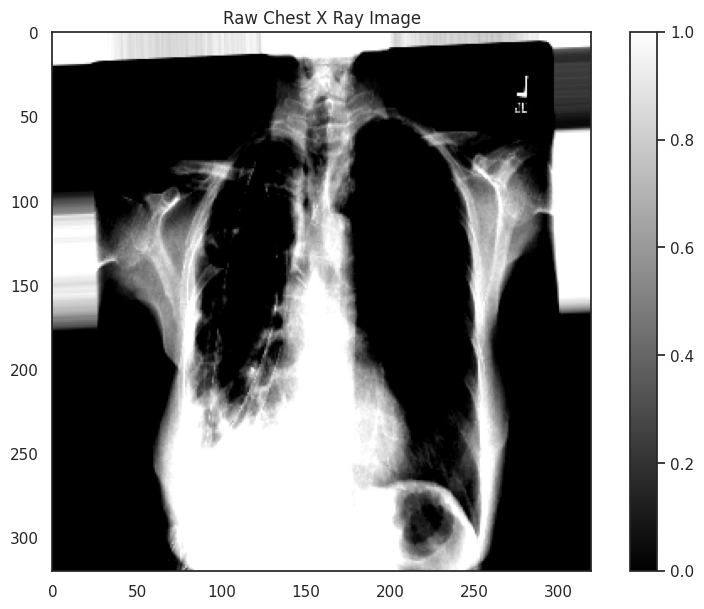

In [20]:
# Plot a processed image
sns.set_style("white")
generated_image, label = train_generator.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [21]:
print(generated_image.shape, generated_image[0].shape)
print(raw_image.shape)

(8, 320, 320, 3) (320, 320, 3)
(1024, 1024)


<ipython-input-22-30006afcf9d9>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_image.ravel(),
<ipython-input-22-30006afcf9d9>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generated_image[0].ravel(),


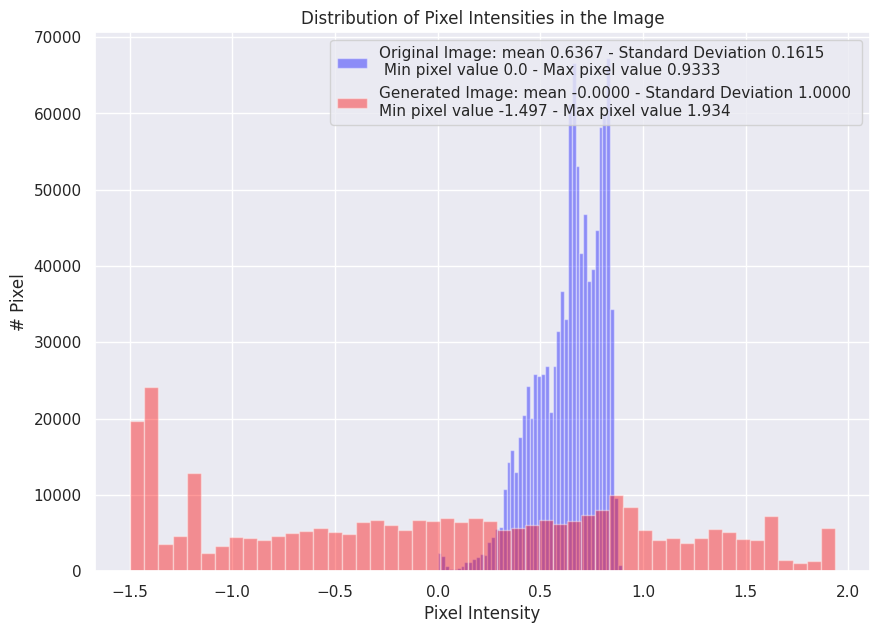

In [22]:
# Include a histogram of the distribution of the pixels
sns.set()
plt.figure(figsize=(10, 7))

# Plot histogram for original iamge
sns.distplot(raw_image.ravel(),
             label=f'Original Image: mean {np.mean(raw_image):.4f} - Standard Deviation {np.std(raw_image):.4f} \n '
             f'Min pixel value {np.min(raw_image):.4} - Max pixel value {np.max(raw_image):.4}',
             color='blue',
             kde=False)

# Plot histogram for generated image
sns.distplot(generated_image[0].ravel(),
             label=f'Generated Image: mean {np.mean(generated_image[0]):.4f} - Standard Deviation {np.std(generated_image[0]):.4f} \n'
             f'Min pixel value {np.min(generated_image[0]):.4} - Max pixel value {np.max(generated_image[0]):.4}',
             color='red',
             kde=False)

# Place legends
plt.legend()
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixel')
plt.show()

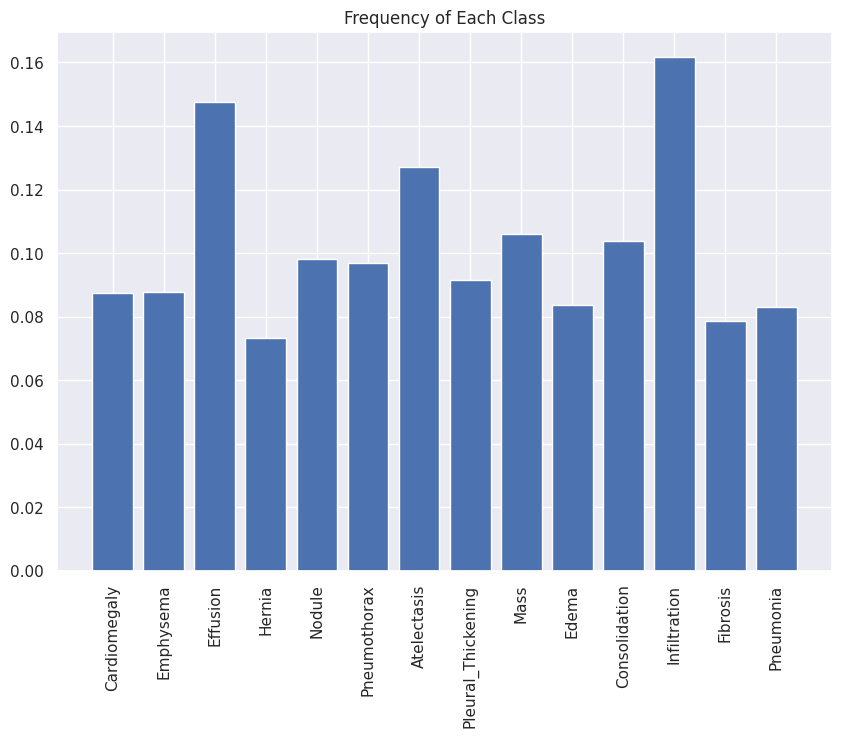

In [23]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [24]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###

    # total number of patients (rows)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0)/N
    negative_frequencies = (N - np.sum(labels, axis=0))/N  # broadcasting of N to a line vector of dim num_classes

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [25]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.0875    , 0.08785714, 0.14767857, 0.07321429, 0.09821429,
       0.09678571, 0.12696429, 0.09160714, 0.10607143, 0.08357143,
       0.10375   , 0.16160714, 0.07857143, 0.08303571])

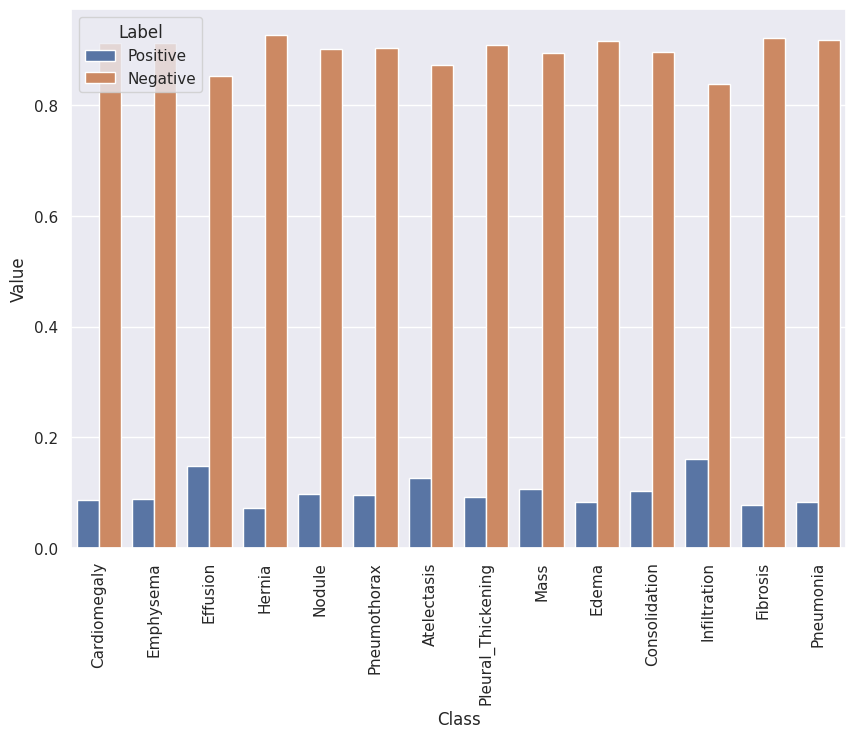

In [26]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})

# Negatif değerler için yeni bir DataFrame oluşturun
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])

# İki DataFrame'i birleştiriyoruz
data = pd.concat([data, data_neg], ignore_index=True)

# Grafik için ayarları yapıyoruz
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

In [27]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights

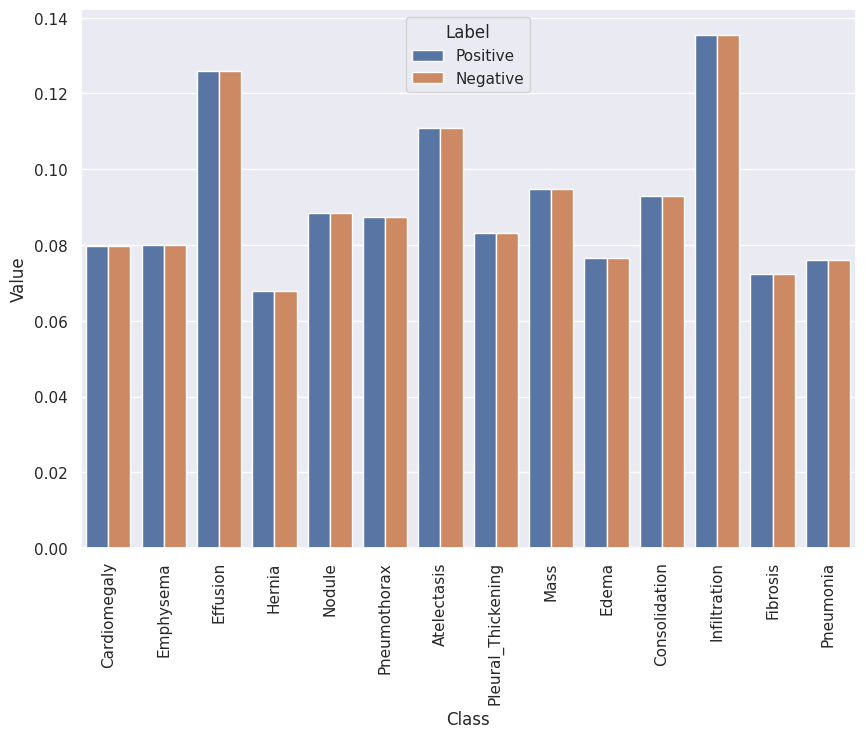

In [28]:
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})

# Negative veriler için yeni DataFrame oluşturuluyor
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])

# DataFrame'leri birleştiriyoruz
data = pd.concat([data_pos, data_neg], ignore_index=True)

# Grafik için ayarları yapıyoruz
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

### Weighted Loss

In [ ]:
# import tensorflow as tf

# def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
#     def weighted_loss(y_true, y_pred):
#         # Initialize loss to zero
#         loss = 0.0

#         # Iterate through each class to calculate weighted loss
#         for i in range(len(pos_weights)):
#             # Calculate the positive class contribution to loss
#             pos_loss = -pos_weights[i] * tf.reduce_mean(y_true[:, i] * tf.math.log(y_pred[:, i] + epsilon))
#             # Calculate the negative class contribution to loss
#             neg_loss = -neg_weights[i] * tf.reduce_mean((1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + epsilon))

#             # Add both positive and negative contributions to the total loss
#             loss += pos_loss + neg_loss

#         return loss

#     return weighted_loss  # This returns a function taking y_true and y_pred as input


In [41]:
import tensorflow as tf
import tensorflow.keras.backend as K

def get_weighted_binary_crossentropy(pos_weights, neg_weights, epsilon=1e-7):
    # Dönüştürülmüş ağırlıkları tensor'a çevir
    pos_weights = tf.constant(pos_weights, dtype=tf.float32)
    neg_weights = tf.constant(neg_weights, dtype=tf.float32)

    def weighted_bce(y_true, y_pred):
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)  # log(0) hatası önlenir

        # Binary crossentropy hesapla (her sınıf için ayrı ayrı)
        loss = - (pos_weights * y_true * tf.math.log(y_pred) +
                  neg_weights * (1. - y_true) * tf.math.log(1. - y_pred))

        return tf.reduce_mean(loss, axis=-1)  # her örnek için ortalama loss döner

    return weighted_bce


In [54]:
from keras.layers import BatchNormalization, Input
from keras.applications import EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import AdamW
from keras.regularizers import l2
from keras.metrics import Precision, Recall, binary_accuracy, AUC
import tensorflow as tf

# F1 score metriğini tanımla
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


def load_C3M3_model(labels, df_all):
    """Optimize edilmiş EfficientNetB0 modeli (val stabilitesine göre ayarlanmış)."""

    # EfficientNetB0 tabanı
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(320, 320, 3))
    print("Loaded EfficientNetB0")

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # İlk normalization + dropout
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Dense katman - daha yüksek dropout ile
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # İkinci dense katman - daha sade
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Çıkış katmanı
    predictions = Dense(len(labels), activation="sigmoid", kernel_regularizer=l2(1e-4))(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)

    # AdamW optimizer
    optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=get_weighted_binary_crossentropy(pos_weights, neg_weights),
        metrics=[
            'accuracy',
            binary_accuracy,
            Precision(),
            Recall(),
            AUC(),
            F1Score()  # Eklenen F1 metriği
        ]
    )
    print("Compiled Model")

    return model


In [55]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
       'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass',
       'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']  # Define the labels list

model = load_C3M3_model(labels, df_all) # Call the function with labels and train_df

Loaded EfficientNetB0
Added layers
Compiled Model


let's see the layers that our model is composed of.

In [56]:
# Print out the total number of layers
layers_ = model.layers
print('total number of layers =',len(layers_))

total number of layers = 248


In [57]:
# The find() method returns an integer value:
# If substring doesn't exist inside the string, it returns -1, otherwise returns first occurence index
conv2D_layers = [layer for layer in model.layers
                if str(type(layer)).find('Conv2D') > -1]

In [58]:
print('Model input -------------->', model.input)
print('Feature extractor output ->', model.get_layer('block6a_project_bn').output)
print('Model output ------------->', model.output)

Model input --------------> <KerasTensor shape=(None, 320, 320, 3), dtype=float32, sparse=False, name=keras_tensor_496>
Feature extractor output -> <KerasTensor shape=(None, 10, 10, 192), dtype=float32, sparse=False, name=keras_tensor_672>
Model output -------------> <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_743>


## Training

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Class Weight Hesaplama Fonksiyonu ---
def get_class_weights(df, labels):
    class_pos = df[labels].sum(axis=0)
    class_neg = len(df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total

    class_weights = {
        i: float(pos_weights[i]) if class_pos[i] > class_neg[i] else float(neg_weights[i])
        for i in range(len(labels))
    }
    return class_weights

# Class weight'leri hesapla
class_weights = get_class_weights(df_all, labels)

# --- Callback'leri tanımla ---
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# --- Modeli eğit ---
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator),
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights  # ✔️ Eklenen satır
)

# --- Eğitim ve doğrulama loss & binary_accuracy grafikleri ---
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history.get('val_loss', []), label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Binary Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label="Training Binary Accuracy")
plt.plot(history.history.get('val_binary_accuracy', []), label="Validation Binary Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Binary Accuracy")
plt.title("Training and Validation Binary Accuracy")
plt.legend()
plt.grid(True)

#  Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Training  Accuracy")
plt.plot(history.history.get('val_accuracy', []), label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


# --- Modeli kaydet ---
model.save("efficientnet_model.h5")
print("Model başarıyla kaydedildi: efficientnet_model.h5 ✅")


<ipython-input-59-7791f8f41a3a>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i: float(pos_weights[i]) if class_pos[i] > class_neg[i] else float(neg_weights[i])


Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 324s 347ms/step - accuracy: 0.0880 - auc_2: 0.5300 - binary_accuracy: 0.5082 - f1_score: 0.1807 - loss: 0.1977 - precision_4: 0.1086 - recall_4: 0.5370 - val_accuracy: 0.0797 - val_auc_2: 0.5887 - val_binary_accuracy: 0.4584 - val_f1_score: 0.1040 - val_loss: 0.1649 - val_precision_4: 0.0567 - val_recall_4: 0.6282 - learning_rate: 1.0000e-04
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 257s 310ms/step - accuracy: 0.1251 - auc_2: 0.6081 - binary_accuracy: 0.5303 - f1_score: 0.2136 - loss: 0.1813 - precision_4: 0.1287 - recall_4: 0.6275 - val_accuracy: 0.0725 - val_auc_2: 0.6708 - val_binary_accuracy: 0.3492 - val_f1_score: 0.1191 - val_loss: 0.1723 - val_precision_4: 0.0639 - val_recall_4: 0.8795 - learning_rate: 1.0000e-04
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 213s 304ms/step - accuracy: 0.1365 - auc_2: 0.6498 - binary_accuracy: 0.5448 - f1_score: 0.2345 - loss: 0.1718 - precision_4: 0.1415 - recall_4: 0.6832 - val_accuracy: 0.0713 - val_auc_2: 0

KeyboardInterrupt: 

In [ ]:
# Modelin ağırlıklarını kaydet
model.save_weights("efficientnet.weights.h5")
print("Model ağırlıkları başarıyla kaydedildi")


Model ağırlıkları başarıyla kaydedildi


In [ ]:
# Modeli .keras formatında kaydet
model.save("efficientnet.keras", save_format="keras")
print("Model başarıyla kaydedildi")


Model başarıyla kaydedildi


## Prediction and Evaluation
Now that we have a model, let's evaluate it using our test set. We can conveniently use the predict_generator function to generate the predictions for the images in our test set.

In [48]:
predicted_vals = model.predict(test_generator, steps=len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict


106/106 ━━━━━━━━━━━━━━━━━━━━ 27s 200ms/step


(841, 14)

### ROC Curve and AUROC
Compute metric called the AUC (Area Under the Curve) from the ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve. ideally we want a curve that is more to the left so that the top has more "area" under it, which indicates that the model is performing better.

In [49]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.savefig('ROC.png')
    plt.show()
    return auc_roc_vals

<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
<ipython-input-39-1bb891fcc9cd>:13: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10)

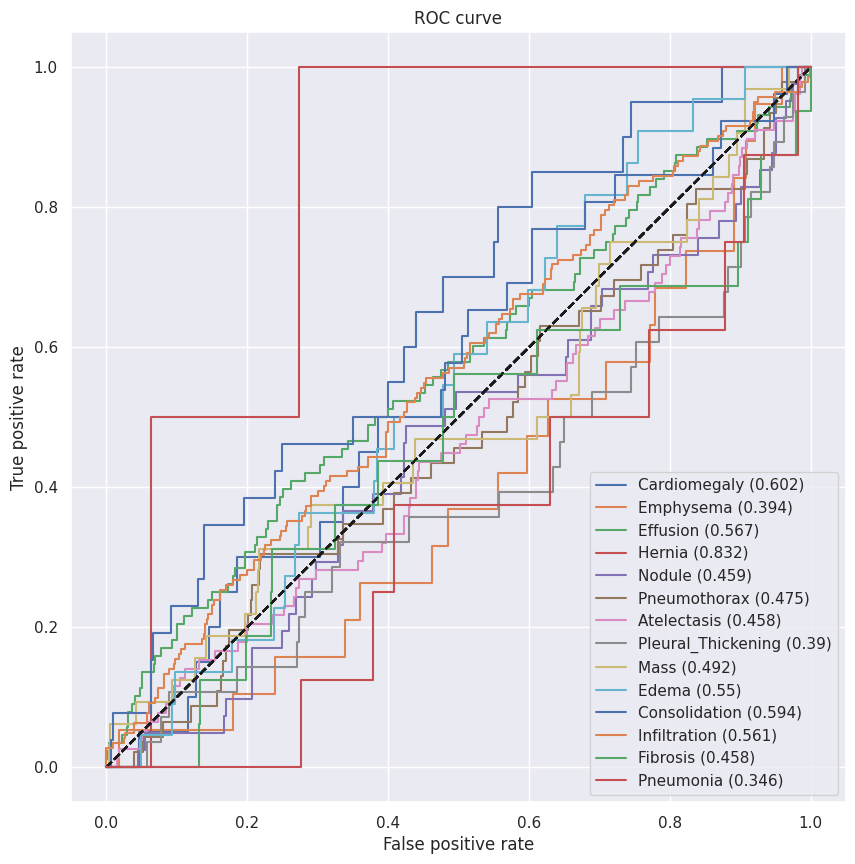

In [40]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [ ]:
print("areas under the curve : {} \n for all {} classes".format(auc_rocs,len(auc_rocs)))

areas under the curve : [np.float64(0.7193666260657734), np.float64(0.7602766039185554), np.float64(0.7558251841120367), np.float64(0.9547079856972587), np.float64(0.5791768292682926), np.float64(0.7696745966639321), np.float64(0.6863091037402963), np.float64(0.6033649622210507), np.float64(0.5353059332509271), np.float64(0.7821067821067821), np.float64(0.6978291647003303), np.float64(0.5905518950613553), np.float64(0.6008333333333333), np.float64(0.4371248499399759)] 
 for all 14 classes


## Interpreting Deep Learning Models

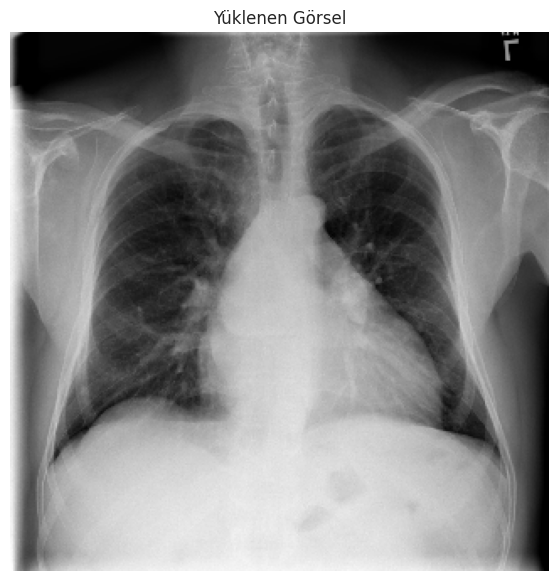

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

🧠 Tahmin Edilen Hastalıklar:
['Cardiomegaly', 'Effusion', 'Nodule', 'Pneumothorax', 'Atelectasis', 'Mass', 'Edema', 'Consolidation', 'Infiltration']


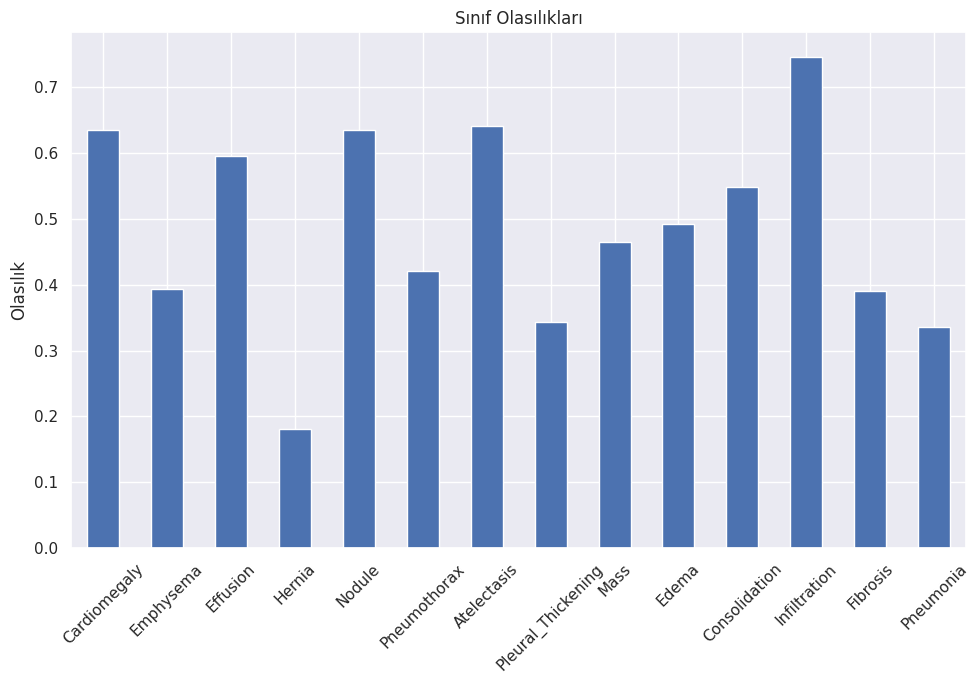

In [53]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Görsel yolu
im_path = '/content/00000001_000.png'

# Görsellerin bulunduğu dizin
IMAGE_DIR = "/content/sample/sample/sample/images/"

# Etiketler (sınıf isimleri)
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia',
          'Nodule', 'Pneumothorax', 'Atelectasis', 'Pleural_Thickening', 'Mass',
          'Edema', 'Consolidation', 'Infiltration', 'Fibrosis', 'Pneumonia']

# ---------- Ortalama ve Standart Sapma Hesabı ----------
def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for img in df.sample(100)["Image Index"].values:
        path = IMAGE_DIR + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))
    sample_data = np.array(sample_data)
    return np.mean(sample_data), np.std(sample_data)

# ---------- Görsel Yükleme ve Normalize Etme ----------
def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x = np.array(x, dtype=np.float32)
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

# ---------- Görseli Görselleştir ----------
raw_img = image.load_img(im_path, target_size=(320, 320))
plt.imshow(raw_img, cmap='gray')
plt.axis('off')
plt.title("Yüklenen Görsel")
plt.show()

# ---------- Normalizasyon için mean/std al ----------
mean, std = get_mean_std_per_batch(train_df)  # train_df daha önce tanımlanmış olmalı

# ---------- Görseli işle ve tahmin yap ----------
processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)

# ---------- Tahmin edilen hastalıklar (threshold ile) ----------
threshold = 0.4
predicted_labels = [label for label, prob in zip(labels, preds[0]) if prob >= threshold]
print("\n🧠 Tahmin Edilen Hastalıklar:")
print(predicted_labels)

# ---------- Tahmin Sonuçlarını Grafikle Göster ----------
pd.DataFrame(preds, columns=labels).loc[0].plot.bar()
plt.title("Sınıf Olasılıkları")
plt.ylabel("Olasılık")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
mean, std = get_mean_std_per_batch(train_df)

In [ ]:
pred_df

,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia
0,0.129122,0.009605,0.138776,0.005024,0.090099,0.02673,0.115216,0.064314,0.157968,0.005389,0.059116,0.118459,0.052772,0.010168
